In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

import select_desi_targets

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

# Remove objects with large sky residuals
for band in ['g', 'r', 'z']:
    subs[band+'_sky'] = (subs['apflux_blobresid_'+band][:, -1]-subs['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (subs['g_sky']>-0.002*2) & (subs['g_sky']<0.002*2)
print(np.sum(mask)/len(mask))
mask &= (subs['r_sky']>-0.003*2) & (subs['r_sky']<0.003*2)
print(np.sum(mask)/len(mask))
mask &= (subs['z_sky']>-0.006*2) & (subs['z_sky']<0.006*2)
print('sky', np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

# Only keep isolated sources
mask = (subs['fracflux_g']>-0.01) & (subs['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_r']>-0.01) & (subs['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_z']>-0.01) & (subs['fracflux_z']<0.01)
print('isolation', np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

mask = np.full(len(subs), True)
for band in ['g', 'r', 'z']:
    mask &= subs['flux_ivar_'+band]>0
subs = subs[mask]
print(len(subs))

# # depth cuts
# min_depths = {'g': 23.8, 'r': 23.3, 'z': 22.6}
# # min_depths = {'g': 24.1, 'r': 23.55, 'z': 22.6}
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     subs['galdepth_gmag_ebv'] = -2.5*(np.log10((5/np.sqrt(subs['galdepth_g'])))-9) - 3.214*subs['ebv']
#     subs['galdepth_rmag_ebv'] = -2.5*(np.log10((5/np.sqrt(subs['galdepth_r'])))-9) - 2.165*subs['ebv']
#     subs['galdepth_zmag_ebv'] = -2.5*(np.log10((5/np.sqrt(subs['galdepth_z'])))-9) - 1.211*subs['ebv']
# mask = np.full(len(subs), True)
# for band in ['g', 'r', 'z']:
#     mask &= subs['galdepth_{}mag_ebv'.format(band)] > min_depths[band]
# print('depth', np.sum(mask)/len(mask))
# subs = subs[mask]
# print(len(subs))

# tmp = Table()
# tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
# tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104
0.9313085551999488
0.882942287064733
sky 0.782445358169604
2153371
0.6551885392716815
0.6204875982819495
isolation 0.5836119275312986
1256733
1256730


In [5]:
mask = subs['sub']=='sub-5'
sub1 = subs[mask].copy()
print(len(sub1))

mask = subs['sub']=='sub-4'
sub2 = subs[mask].copy()
print(len(sub2))

108141
99783


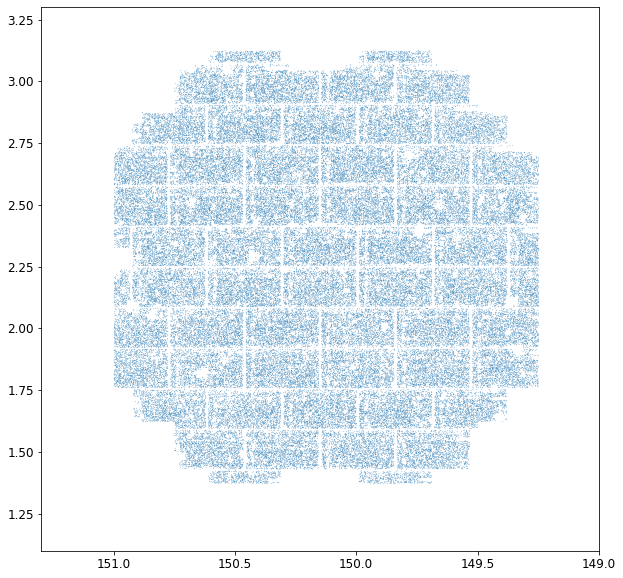

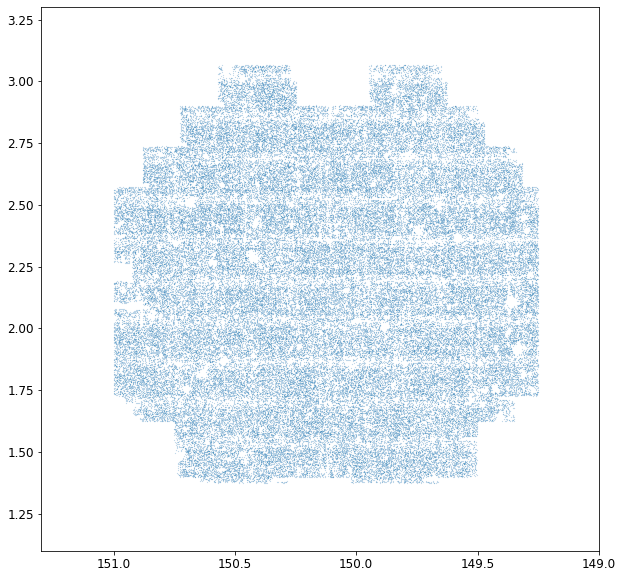

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(sub2['ra'], sub2['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

Doubly matched objects = 0
Final matched objects = 61490


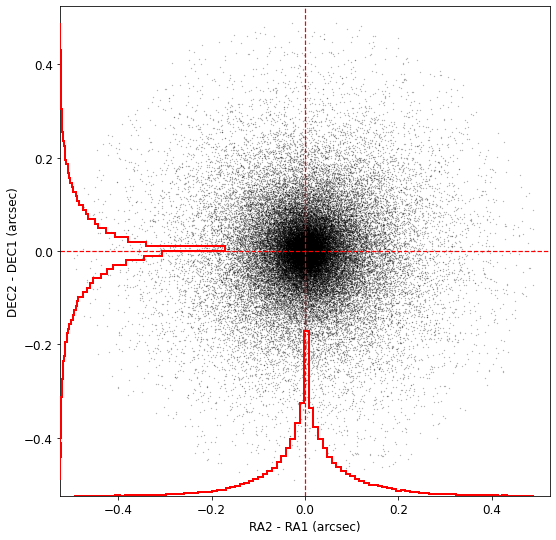

In [7]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], sub2['ra'], sub2['dec'], search_radius=0.5, plot_q=True)

sub1 = sub1[idx1]
sub2 = sub2[idx2]

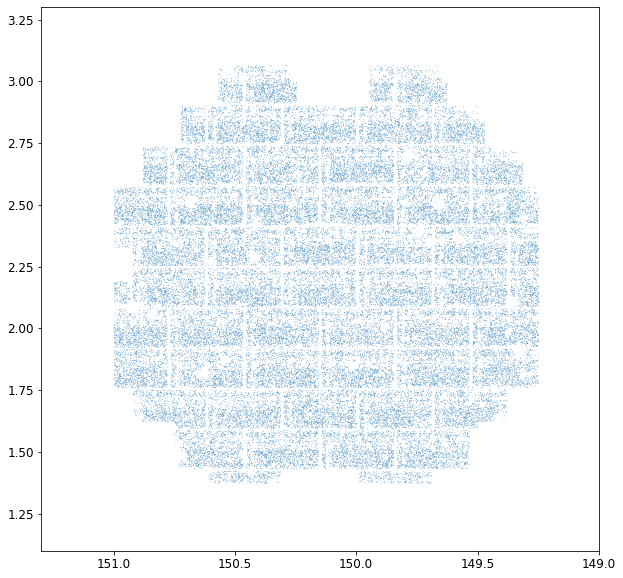

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

113841
Doubly matched objects = 0
Final matched objects = 42216


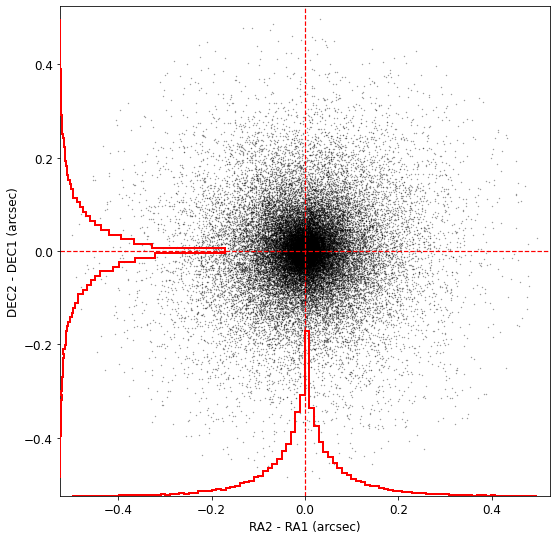

1304 346


In [9]:
# Use a different subset to select an unbiased ELG sample
mask = subs['sub']=='dr9_ccds'
sub3 = subs[mask].copy()
print(len(sub3))

idx1, idx2, d2d, d_ra, d_dec = match_coord(sub3['ra'], sub3['dec'], sub1['ra'], sub1['dec'], search_radius=0.5, plot_q=True)
sub1 = sub1[idx2]
sub2 = sub2[idx2]
sub3 = sub3[idx1]
elglop, elgvlo = select_desi_targets.select_elgs(sub3)
print(np.sum(elglop), np.sum(elgvlo))

In [10]:
mask0 = elglop.copy()

print('{:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_g'][mask0]), np.median(sub2['psfsize_g'][mask0]), np.median(sub1['psfsize_g'][mask0])-np.median(sub2['psfsize_g'][mask0])))
print('{:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_r'][mask0]), np.median(sub2['psfsize_r'][mask0]), np.median(sub1['psfsize_r'][mask0])-np.median(sub2['psfsize_r'][mask0])))
print('{:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_z'][mask0]), np.median(sub2['psfsize_z'][mask0]), np.median(sub1['psfsize_z'][mask0])-np.median(sub2['psfsize_z'][mask0])))

1.311  1.299  0.012
1.089  1.115  -0.026
1.151  1.169  -0.018


In [11]:
# tmp = Table()
# tmp['type'], tmp['count'] = np.unique(sub1['type'][mask0], return_counts=True)
# tmp['frac (%)'] = tmp['count']/np.sum(mask0)*100
# tmp['frac (%)'].format = '%.1f'
# tmp.sort('count')
# tmp.pprint_all()
# print()

In [12]:
mask0 = elglop.copy()

tmp1 = Table()
tmp1['type'], tmp1['count_1'] = np.unique(sub1['type'][mask0], return_counts=True)
tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
tmp1['frac_1'].format = '%.1f'

tmp2 = Table()
tmp2['type'], tmp2['count_2'] = np.unique(sub2['type'][mask0], return_counts=True)
tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
tmp2['frac_2'].format = '%.1f'

tmp = join(tmp1, tmp2, keys='type', join_type='outer')

tmp['frac_agree_1'] = 0.
tmp['frac_agree_1'].format = '%.1f'
tmp['frac_agree_2'] = 0.
tmp['frac_agree_2'].format = '%.1f'
for index, tt in enumerate(tmp['type']):
    mask = mask0 & (sub1['type']==tt) & (sub2['type']==tt)
    tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(sub1['type'][mask0]==tt) * 100
    tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub2['type'][mask0]==tt) * 100
    
tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
tmp.pprint_all()

type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      20      21    1.5    1.6         25.0         23.8
 EXP     165     151   12.7   11.6         60.0         65.6
 PSF     365     378   28.0   29.0         72.6         70.1
 REX     752     752   57.7   57.7         78.2         78.2
 SER       2       2    0.2    0.2        100.0        100.0


In [13]:
mask0 = elglop.copy()
mask0 &= sub3['gfibermag']>23.6

tmp1 = Table()
tmp1['type'], tmp1['count_1'] = np.unique(sub1['type'][mask0], return_counts=True)
tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
tmp1['frac_1'].format = '%.1f'

tmp2 = Table()
tmp2['type'], tmp2['count_2'] = np.unique(sub2['type'][mask0], return_counts=True)
tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
tmp2['frac_2'].format = '%.1f'

tmp = join(tmp1, tmp2, keys='type', join_type='outer')

tmp['frac_agree_1'] = 0.
tmp['frac_agree_1'].format = '%.1f'
tmp['frac_agree_2'] = 0.
tmp['frac_agree_2'].format = '%.1f'
for index, tt in enumerate(tmp['type']):
    mask = mask0 & (sub1['type']==tt) & (sub2['type']==tt)
    tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(sub1['type'][mask0]==tt) * 100
    tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub2['type'][mask0]==tt) * 100
    
tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
tmp.pprint_all()

type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV       8       8    0.9    0.9         25.0         25.0
 EXP      93      88   10.1    9.6         58.1         61.4
 PSF     231     238   25.1   25.9         61.0         59.2
 REX     587     585   63.9   63.7         77.9         78.1


In [14]:
mask0 = elglop.copy()

for tt in np.unique(sub2['type']):
    mask = mask0 & (sub2['type']==tt)
    print(tt, np.sum(mask))
    tmp = Table()
    tmp['type'], tmp['count'] = np.unique(sub1['type'][mask], return_counts=True)
    tmp['frac (%)'] = tmp['count']/np.sum(mask)*100
    tmp['frac (%)'].format = '%.1f'
    tmp.sort('count')
    tmp.pprint_all()
    print()

DEV 21
type count frac (%)
---- ----- --------
 PSF     2      9.5
 EXP     4     19.0
 DEV     5     23.8
 REX    10     47.6

EXP 151
type count frac (%)
---- ----- --------
 PSF     2      1.3
 DEV     8      5.3
 REX    42     27.8
 EXP    99     65.6

PSF 378
type count frac (%)
---- ----- --------
 DEV     1      0.3
 REX   112     29.6
 PSF   265     70.1

REX 752
type count frac (%)
---- ----- --------
 DEV     6      0.8
 EXP    62      8.2
 PSF    96     12.8
 REX   588     78.2

SER 2
type count frac (%)
---- ----- --------
 SER     2    100.0



----------
## All subsets

In [15]:
for subset_pair in [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9]]:

    print('sub-{} vs sub-{}'.format(subset_pair[0], subset_pair[1]))

    mask = subs['sub']=='sub-{}'.format(subset_pair[0])
    sub1 = subs[mask].copy()
    # print(len(sub1))

    mask = subs['sub']=='sub-{}'.format(subset_pair[1])
    sub2 = subs[mask].copy()
    # print(len(sub2))


    idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], sub2['ra'], sub2['dec'], search_radius=0.5, plot_q=False, verbose=False)

    sub1 = sub1[idx1]
    sub2 = sub2[idx2]


    # Use a different subset to select an unbiased ELG sample
    mask = subs['sub']=='dr9_ccds'
    sub3 = subs[mask].copy()
    # print(len(sub3))

    idx1, idx2, d2d, d_ra, d_dec = match_coord(sub3['ra'], sub3['dec'], sub1['ra'], sub1['dec'], search_radius=0.5, plot_q=False, verbose=False)
    sub1 = sub1[idx2]
    sub2 = sub2[idx2]
    sub3 = sub3[idx1]
    elglop, elgvlo = select_desi_targets.select_elgs(sub3)
    # print(np.sum(elglop), np.sum(elgvlo))

    mask0 = elglop.copy()

    print('psfsize_g: {:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_g'][mask0]), np.median(sub2['psfsize_g'][mask0]), np.median(sub1['psfsize_g'][mask0])-np.median(sub2['psfsize_g'][mask0])))
    print('psfsize_r: {:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_r'][mask0]), np.median(sub2['psfsize_r'][mask0]), np.median(sub1['psfsize_r'][mask0])-np.median(sub2['psfsize_r'][mask0])))
    print('psfsize_z: {:.3f}  {:.3f}  {:.3f}'.format(np.median(sub1['psfsize_z'][mask0]), np.median(sub2['psfsize_z'][mask0]), np.median(sub1['psfsize_z'][mask0])-np.median(sub2['psfsize_z'][mask0])))

    tmp1 = Table()
    tmp1['type'], tmp1['count_1'] = np.unique(sub1['type'][mask0], return_counts=True)
    tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
    tmp1['frac_1'].format = '%.1f'

    tmp2 = Table()
    tmp2['type'], tmp2['count_2'] = np.unique(sub2['type'][mask0], return_counts=True)
    tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
    tmp2['frac_2'].format = '%.1f'

    tmp = join(tmp1, tmp2, keys='type', join_type='outer')

    tmp['frac_agree_1'] = 0.
    tmp['frac_agree_1'].format = '%.1f'
    tmp['frac_agree_2'] = 0.
    tmp['frac_agree_2'].format = '%.1f'
    for index, tt in enumerate(tmp['type']):
        mask = mask0 & (sub1['type']==tt) & (sub2['type']==tt)
        tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(sub1['type'][mask0]==tt) * 100
        tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub2['type'][mask0]==tt) * 100
        
    tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
    tmp.pprint_all()

    print()
    print()

sub-0 vs sub-1
psfsize_g: 1.635  1.426  0.209
psfsize_r: 1.217  1.061  0.156
psfsize_z: 1.143  1.146  -0.004
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV       4       7    0.6    1.1         50.0         28.6
 EXP      27      62    4.1    9.5         81.5         35.5
 PSF     243     212   37.2   32.4         61.3         70.3
 REX     380     373   58.1   57.0         73.2         74.5


sub-1 vs sub-2
psfsize_g: 1.430  1.187  0.243
psfsize_r: 1.063  1.485  -0.422
psfsize_z: 1.146  1.132  0.014
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV       8       9    0.8    0.9         25.0         22.2
 EXP      80      94    8.3    9.8         67.5         57.4
 PSF     318     300   33.2   31.3         67.9         72.0
 REX     553     555   57.7   57.9         77.6         77.3
 SER      --       1     --    0.1          nan 

/tmp/ipykernel_248031/3290975437.py:56: RuntimeWarning: invalid value encountered in long_scalars
  tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(sub1['type'][mask0]==tt) * 100


psfsize_g: 1.187  1.142  0.045
psfsize_r: 1.485  1.390  0.095
psfsize_z: 1.129  1.235  -0.106
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      18      22    1.3    1.6         22.2         18.2
 EXP     141     167   10.0   11.8         68.8         58.1
 PSF     473     451   33.5   32.0         70.0         73.4
 REX     777     769   55.1   54.5         75.9         76.7
 SER       2       2    0.1    0.1        100.0        100.0


sub-3 vs sub-4
psfsize_g: 1.137  1.302  -0.166
psfsize_r: 1.388  1.115  0.273
psfsize_z: 1.233  1.169  0.064
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      22      19    1.7    1.4          9.1         10.5
 EXP     148     172   11.1   12.9         68.2         58.7
 PSF     417     384   31.4   28.9         69.1         75.0
 REX     741     753   55.7   56.6         78.4         77.2
 S